In [1]:
import pandas as pd
import numpy as np
print('Project Proposal!')

Project Proposal!


In [2]:
!pip install lxml html5lib beautifulsoup4


#### Scrape Wikipedia page in order to obtain the data that is the table of postal codes in Toronto, CA and to transform the data into a pandas  dataframe

In [2]:
#import table and print number of tables
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)

print(len(dfs))

3


In [3]:
#check first table. Looks like table we want

dfs[0].head(10)
print(dfs[0].columns)
canada_df = dfs[0]
canada_df = canada_df.stack().reset_index()
#for columns in canada_df.columns:

canada_df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')


Index(['level_0', 'level_1', 0], dtype='object')

In [4]:

#set 1st table as canada_df and then drop rows where borough is not assigned

canada_df = canada_df[canada_df[0].str.contains('Not assigned') == False]
canada_df['Postal Code'] = canada_df[0].str.slice(0,3)
canada_df['Borough'] = canada_df[0].str[3:]
canada_df['Borough'] = canada_df['Borough'].str.replace(r"\(.*\)","")
canada_df['Neighborhood'] = canada_df[0].str.extract(r"\((.*?)\)", expand=False)
canada_df = canada_df[['Postal Code', 'Borough', 'Neighborhood']]
canada_df



,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
169,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


In [5]:
#combine rows by postal codes, for all neighborhoods within the postal code
canada_df = canada_df.groupby('Postal Code', as_index=False).agg(','.join)
canada_df

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...
101,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...


#### Generate geospatial coordinates for all postcodes

In [6]:
!pip install pgeocode
##geocode helps get coordinates from postal codes
import pgeocode

#create lat and long columns
canada_df['Latitude'] = np.nan
canada_df['Longitude'] = np.nan

for idx, row in canada_df.iterrows():
    address = row['Postal Code']
    nomi = pgeocode.Nominatim('ca')
    location  = nomi.query_postal_code(row['Postal Code'])
    canada_df.loc[idx,'Latitude'] = location.latitude
    canada_df.loc[idx,'Longitude'] = location.longitude

canada_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.1930
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866
3,M1G,Scarborough,Woburn,43.7712,-79.2144
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


In [7]:
#check if any value is NaN
import math
print(pd.isnull(canada_df).value_counts())

##fill latitude and longitude based on csv file provided in the project
geo_coord = pd.read_csv('Geospatial_Coordinates.csv')

geo_coord['Latitude']
#canada_df[(canada_df['Postal Code'] == 'M7R')]['Latitude'] = 43.6369656
#canada_df[(canada_df['Postal Code'] == 'M7R')]['Longitude'] = -79.615819

for idx, row in canada_df.iterrows():
    if math.isnan(row['Latitude']) or math.isnan(row['Latitude']):
        print(row['Postal Code'], geo_coord[(geo_coord['Postal Code'] == row['Postal Code'])]['Latitude'].values)
        canada_df.loc[idx, 'Latitude' ] = geo_coord[(geo_coord['Postal Code'] == row['Postal Code'])]['Latitude'].values
        canada_df.loc[idx, 'Longitude' ] = geo_coord[(geo_coord['Postal Code'] == row['Postal Code'])]['Longitude'].values
    


Postal Code  Borough  Neighborhood  Latitude  Longitude
False        False    False         False     False        102
                                    True      True           1
dtype: int64
M7R [43.6369656]


In [8]:
#check if any NaN remains
print(pd.isnull(canada_df).value_counts())
canada_df.head()


Postal Code  Borough  Neighborhood  Latitude  Longitude
False        False    False         False     False        103
dtype: int64


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.1930
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866
3,M1G,Scarborough,Woburn,43.7712,-79.2144
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


In [9]:
canada_df.to_csv('Toronto_Boroughs_LongLat.csv', index=False)

#### Import Libraries to draw map and cluster neighborhoods

In [10]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [11]:
#generate latitude and longitude of toronto
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of Map using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(canada_df['Latitude'], canada_df['Longitude'], canada_df['Borough'], canada_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Using kmeans clustering to cluster neighborhoods whose borough has Toronto contained its name using

In [13]:
##set Foursqure credentials

CLIENT_ID = 'UC4WQCBV4YLRIZ32PRJ1UCEAH1ADSCVSKYHILZYF5EDSEBJC' # your Foursquare ID
CLIENT_SECRET = 'QSFQJCOYILYWM3HUIX3CHL4X2SEOPATWJ55FBU0V5PHXD5SR' # your Foursquare Secret
ACCESS_TOKEN = 'ADLUOVQNW2Q0VW5U2SPKA1B3H1Q4X4C3VPFIT0JMUPRZAHFY' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: UC4WQCBV4YLRIZ32PRJ1UCEAH1ADSCVSKYHILZYF5EDSEBJC
CLIENT_SECRET:QSFQJCOYILYWM3HUIX3CHL4X2SEOPATWJ55FBU0V5PHXD5SR


In [14]:
###get nearby venues accross all neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#data of all venues within 800 metres of each neighbourhood will be stored in toronto_venues

toronto_venues = getNearbyVenues(canada_df['Neighborhood'], canada_df['Latitude'], canada_df['Longitude'])

print(toronto_venues.shape)
toronto_venues.head()

Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview / Henry Farm / Oriole
Bayview Village
York Mills / Silver Hills
Willowdale / Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor / Wilson Heights / Downsview North
Northwood Park / York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill / Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth East
The Danforth West / Riverdale
India Bazaar / The Bea

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern / Rouge,43.8113,-79.1930,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
1,Malvern / Rouge,43.8113,-79.1930,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
2,Malvern / Rouge,43.8113,-79.1930,Upper Rouge Trail,43.809988,-79.186147,Trail
3,Malvern / Rouge,43.8113,-79.1930,Grizzly Bear Exhibit,43.817031,-79.193458,Zoo Exhibit
4,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564,Centennial Park,43.786257,-79.148776,Park


In [17]:
#checking how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,35,35,35,35,35,35
Alderwood / Long Branch,10,10,10,10,10,10
Bathurst Manor / Wilson Heights / Downsview North,28,28,28,28,28,28
Bayview Village,5,5,5,5,5,5
Bedford Park / Lawrence Manor East,34,34,34,34,34,34
Berczy Park,100,100,100,100,100,100
Birch Cliff / Cliffside West,10,10,10,10,10,10
Brockton / Parkdale Village / Exhibition Place,100,100,100,100,100,100
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport,100,100,100,100,100,100


In [18]:
#Analyzing each neighborhood

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
col_list = toronto_onehot.columns.tolist()


#remove Neighborhood from list
col_list.remove("Neighborhood")



# move neighborhood column to the first column
fixed_columns = ["Neighborhood"] + col_list
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

There are 328 uniques categories.


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaur

In [19]:
# group the rows by neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()
toronto_grouped.to_csv('torontonamed_grouped.csv', index = False)

(97, 328)


In [20]:
##function to sort venues in desecding order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
###pick 12 highest venue for each neighborhood
num_top_venues = 12

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

neighborhoods_venues_sorted.to_csv('torontonamed_neighborhoods_sorted.csv', index=False)

In [41]:
##Use K Means to cluster the Neighborhood
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 1, 2, 0, 1], dtype=int32)

In [42]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = canada_df

# merge toronto_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(50) # check the last columns!
toronto_merged.dropna(inplace=True)

In [45]:
#Visualizing resulting cluster

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
#cluster distribution

toronto_merged['Cluster Labels'].value_counts()



2.0    86
1.0    11
0.0     5
Name: Cluster Labels, dtype: int64

#### Results show that a large amout of the clusters are of label 0. Indicating similarity in neighborhoods around anlyzed borough

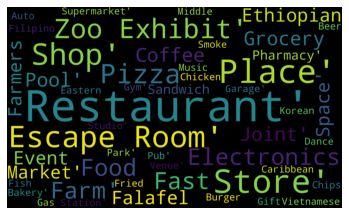

Word Cloud for Toronto Venues, Cluster Label 0


In [48]:
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

torcluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]


stopwords = set(STOPWORDS)
# instantiate a word cloud object
text = torcluster0[torcluster0.columns[1:]].values
neigh_wc = WordCloud(
    background_color='black',
    width = 5000,
    height = 3000,
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
neigh_wc.generate(str(text))

# display the word cloud
plt.imshow(neigh_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


print('Word Cloud for Toronto Venues, Cluster Label 0')

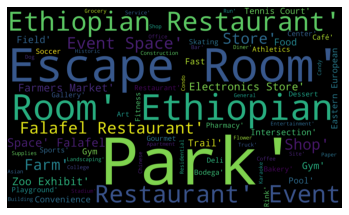

Word Cloud for Toronto Venues, Cluster Label 1


In [49]:
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

torcluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]


stopwords = set(STOPWORDS)
# instantiate a word cloud object
text = torcluster1[torcluster1.columns[1:]].values
neigh_wc = WordCloud(
    background_color='black',
    width = 5000,
    height = 3000,
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
neigh_wc.generate(str(text))

# display the word cloud
plt.imshow(neigh_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


print('Word Cloud for Toronto Venues, Cluster Label 1')

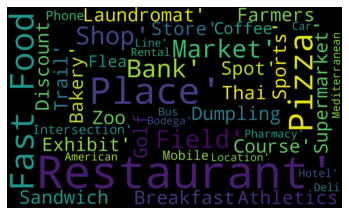

Word Cloud for Toronto Venues, Cluster Label 2


In [50]:
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

torcluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]


stopwords = set(STOPWORDS)
# instantiate a word cloud object
text = torcluster2[torcluster2.columns[1:]].values
neigh_wc = WordCloud(
    background_color='black',
    width = 5000,
    height = 3000,
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
neigh_wc.generate(str(text))

# display the word cloud
plt.imshow(neigh_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


print('Word Cloud for Toronto Venues, Cluster Label 2')